In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, pi, sin, deg2rad, rad2deg
from numpy.linalg import eig

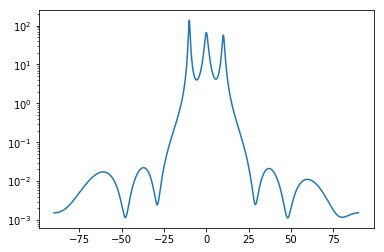

In [73]:
SNR = 20
snapshots = 200
sensorNum = 8
#----------Consider a ULA, where the array sapcing is a half wavelength of the signal.--------#
c = 3e8
f = 2.4e9                       # frequency is 2.4GHz
wavelength = c / f              # lambda
spacing = wavelength / 2        # ULA's spacing

#---------Sample: sample frequency is fs = 3f-------------------------------------------#
fs = 3 * f                      
Ts = 1 / fs                             # Sample period
Ns = Ts * np.arange(snapshots)          # Sample spacing

#----------Consider noises are generated from a zero mean Gaussian distribution.--------------#
sigma_N = 0.1
noiseCovMat = np.diag(sigma_N * np.ones(sensorNum))    

noiseAmp = np.random.multivariate_normal(np.zeros(sensorNum), noiseCovMat, snapshots)
noisePhase = np.mat([exp(-1j*2*pi*f*Ns + np.random.rand())])
noiseMat = np.multiply(noiseAmp, noisePhase.T)                    # Each row is A sample 

#----------Consider four uncorrlated sources at -25 degree, 0 degree and 25 degree,-------#
#----------Each source is generated from a zerom mean Gaussian distribution.------------------#    
theta_S = np.array([-10, 0, 10])
sourceNum = len(theta_S)
sigma_S = sigma_N * 10**(SNR/20)
signalCovMat = np.diag(sigma_S * np.ones(sourceNum))
signalAmp = np.random.multivariate_normal(np.zeros(sourceNum), signalCovMat, snapshots)
signalPhase = np.mat([exp(-1j*2*pi*f*Ns + np.random.rand())])
signalMat = np.multiply(signalAmp, signalPhase.T)                # Each row is A sample 

spacingK = spacing * np.arange(sensorNum)
manifoldMat = np.zeros((sensorNum, sourceNum), dtype=complex)
for col in range(manifoldMat.shape[1]):
        manifoldMat[:, col] = np.mat([exp(-1j*2*pi*f*((spacingK*np.sin(np.deg2rad(theta_S[col])))/c))], dtype=complex)

sensorOut = np.dot(manifoldMat, signalMat.T) + noiseMat.T
covMat_Hat = np.dot(sensorOut, sensorOut.H) / snapshots
eigenVals, eigenVects = eig(covMat_Hat)
eigenValsIdx = np.argsort(-eigenVals)
signalSubspace = eigenVects[:, eigenValsIdx[np.arange(sourceNum)]]
noisySubspace = eigenVects[:, eigenValsIdx[np.arange(sourceNum, sensorNum)]]

noisyPower_Hat = (1/(sensorNum - sourceNum))*np.sum(eigenVals[np.arange(sourceNum, sensorNum)])
R = np.mat(np.diag(eigenVals[eigenValsIdx[np.arange(sourceNum)]]) - noisyPower_Hat*np.eye(sourceNum))
noiseFreeMatPinv = np.dot(np.dot(signalSubspace, R.I), signalSubspace.H)

theta = np.arange(-90, 90, 0.1)
P_SS_MUSIC = np.zeros(len(theta), dtype=complex)
for itr in range(len(theta)):
    steeringVec = np.mat(exp(-1j*2*pi*f*(spacingK*sin(deg2rad(theta[itr]))/c))).T
    P_SS_MUSIC[itr] = (steeringVec.H*noiseFreeMatPinv*steeringVec) / (steeringVec.H*noisySubspace*noisySubspace.H*steeringVec)
plt.semilogy(theta, abs(P_SS_MUSIC))
plt.show()